In [1]:
from neuron import h
from neuron.units import ms, mV
%matplotlib notebook
h.load_file('stdrun.hoc')

1.0

In [2]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend1 = h.Section(name='dend', cell=self)
        self.dend2 = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend1, self.dend2]
        self.dend1.connect(self.soma(0))
        self.dend2.connect(self.soma(1))
        self.soma.L = self.soma.diam = 18.8
        
        self.dend1.L = 701.9
        self.dend1.diam = 3.18
        self.dend1.nseg = 5
        
        self.dend2.L = 549.1
        self.dend2.diam = 2.0
        self.dend2.nseg = 5
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 123    # Axial resistance in Ohm * cm
#             sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh') 
#         self.dend.insert('pas')
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
#         for seg in self.dend:
#             seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
#             seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
#             seg.hh.gl = 0.0003    # Leak conductance in S/cm2
#             seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite                       # <-- NEW
        self.dend1.insert('pas')                                        # <-- NEW
        for seg in self.dend1:                                          # <-- NEW
            seg.pas.g = .0001667 # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -60    # Leak reversal potential mV            # <-- NEW 
            
        self.dend2.insert('pas')                                        # <-- NEW
        for seg in self.dend2:                                          # <-- NEW
            seg.pas.g = .0001666  # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -60    # Leak reversal potential mV            # <-- NEW 
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

In [3]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `----|       BallAndStick[0].dend(0-1)
 `----|       BallAndStick[0].dend(0-1)



1.0

<IPython.core.display.Javascript object>


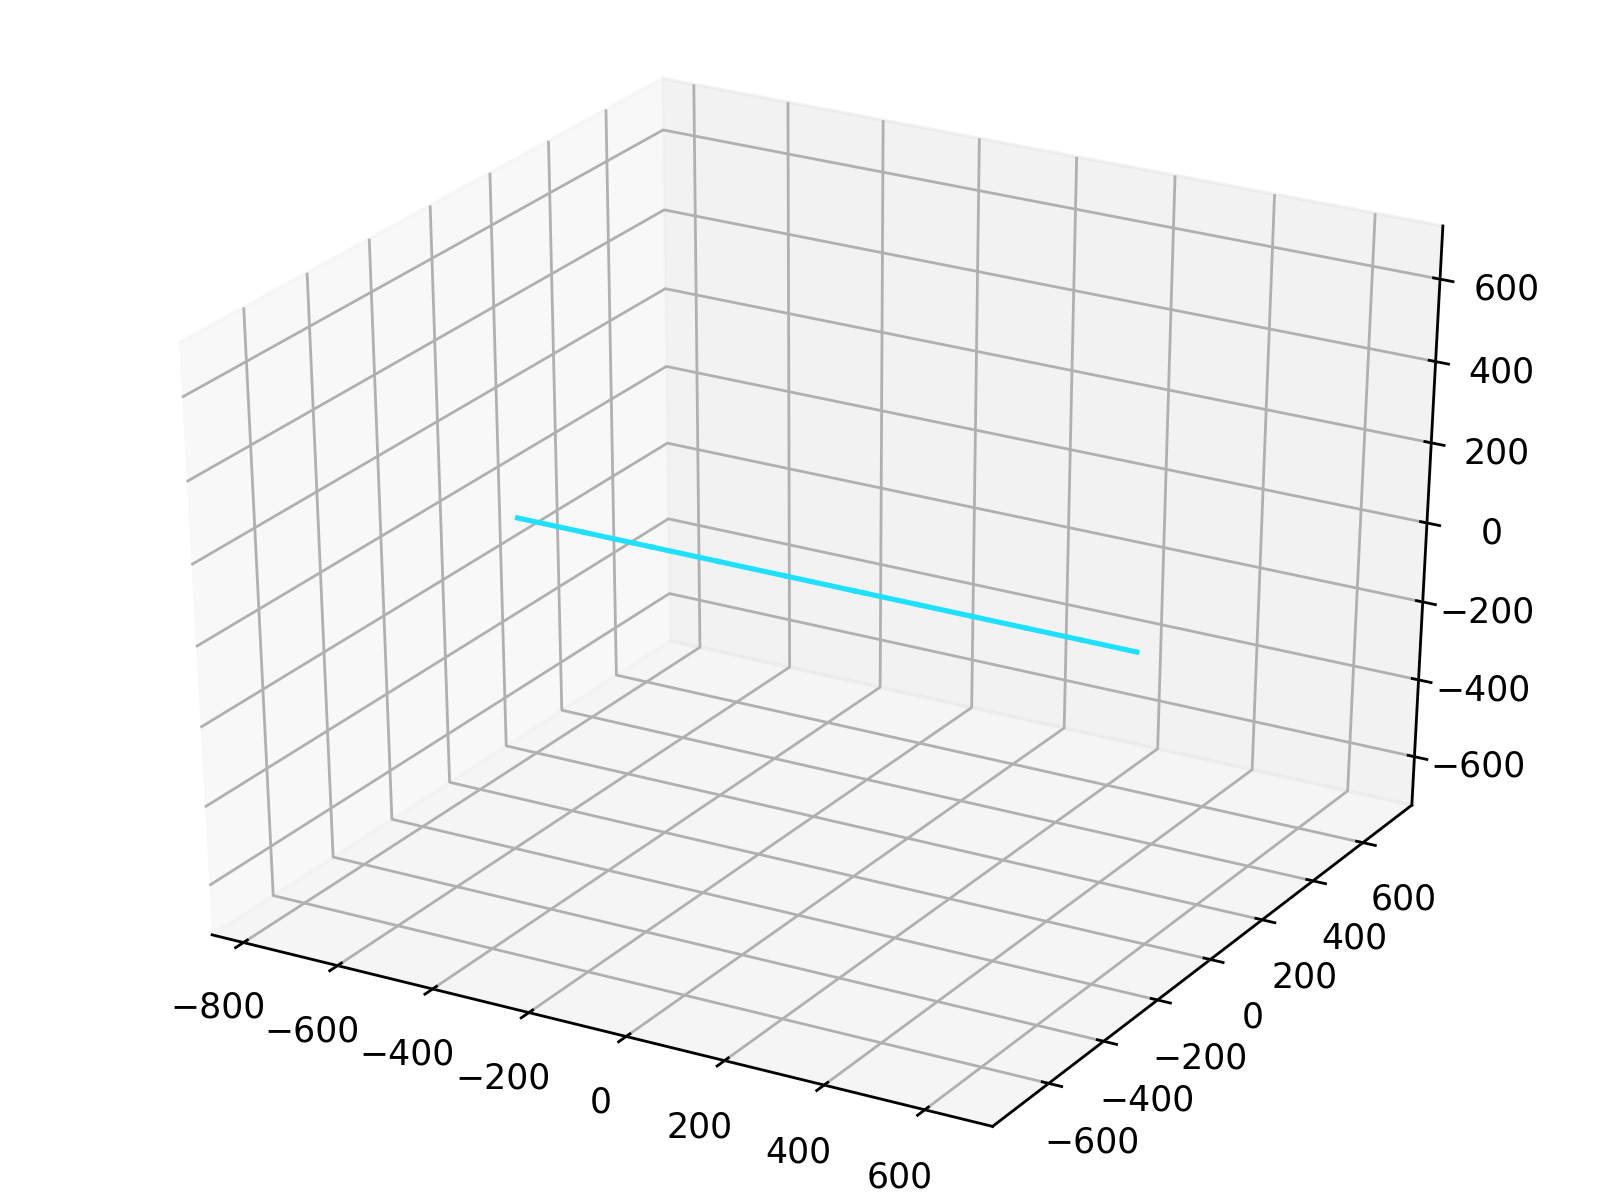

<neuron._PlotShapePlot.__call__.<locals>._get_pyplot_axis3d.<locals>.Axis3DWithNEURON at 0x1260f22e8>

In [4]:
import matplotlib.pyplot as plt

h.PlotShape(False).plot(plt)

In [ ]:
ps = h.PlotShape(True)
ps.show(0)

In [5]:
for sec in h.allsec():
    print('%s: %s' % (sec, ', '.join(sec.psection()['density_mechs'].keys())))

BallAndStick[0].soma: hh
BallAndStick[0].dend: pas
BallAndStick[0].dend: pas


# Stimulation on Soma

In [5]:
from bokeh.io import output_notebook
import bokeh.plotting as bplt
from scipy import signal
from scipy.signal import butter, lfilter
import numpy as np
output_notebook()

Loading BokehJS ...

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Distribution map

In [ ]:
# import scipy.io as sio
# import matplotlib.pyplot as plt
# %matplotlib inline

In [ ]:
# Dmap = sio.loadmat('/Users/xinzonghao/Desktop/matlabtool/TI/inverse2/testmap/Neuron/Vggy.mat')
# # HA = Dmap['testdata2']
# data2 = Dmap['mapVggy']
# print(data2.shape)

In [ ]:
# # data_stack = np.hstack((data2[20,30,:],data2[20,30,:],data2[20,30,:]))
# data_stack = np.tile(data2[20,20,:],3)
# x=np.arange(data_stack.shape[0])
# plt.plot(x,data_stack)
# plt.show()


In [ ]:
# print(data_stack.shape)

In [ ]:
# maxnum = np.max(HA[20:60, 20:60])
# HA = HA * 0.2 / maxnum
# plt.imshow(HA)
# [row, col] = HA.shape

In [19]:
# Neural stimulation type 1
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
# rcParams['font.family'] = 'Times New Roman'
# plt.rcParams["font.weight"] = "bold"

def neural_sti(amp,freq=20):
    stim = h.MyClamp2(my_cell.soma(0.5))
#     stim = h.myenv(my_cell.soma(0.5))

    print(', '.join(item for item in dir(stim) if not item.startswith('__')))

    stim.delay = 5
    stim.dur = 2000
    stim.pkamp1 = amp
    stim.pkamp2 = amp
    stim.pkamp3 = amp
    stim.pkamp4 = amp
    stim.freq1 = 1000
    stim.freq2 = 5000
    stim.freq3 = 1010
    stim.freq4 = 5010

#     stim.delay = 5
#     stim.dur = 2000
#     stim.amp = amp
#     stim.freq = freq

    soma_v = h.Vector().record(my_cell.soma(0.8)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-65 * mV)
    h.continuerun(1000 * ms)


#     f = bplt.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
#     f.line(t, soma_v, line_width=2)
#     bplt.show(f)

    data = soma_v.as_numpy()

    fs = 1/(h.dt/1000)
    filt_data = butter_bandpass_filter(data, 50, 200, fs, order=3)
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax2.plot(t,filt_data,'r',label = 'Membrane potential')
    ax2.set_ylim([-40, 60])
    
    inject_current1 = 20*np.sin(2*np.pi*(t+5))
    inject_current2 = 20*np.sin(2*np.pi*(t+5)*1.01)
    inject_current3 = 20*np.sin(2*np.pi*(t+5)*5)
    inject_current4 = 20*np.sin(2*np.pi*(t+5)*5.01)
    inject_current = inject_current1 + inject_current2 + inject_current3 + inject_current4
    font = {
        'weight': 'heavy',
        'size': 20,
       }
    ax1.plot(t,inject_current,'y',label = 'Injected current')
    ax1.set_ylim([-100, 100])
    ax1.set_ylabel("Inteference wave ($\mathbf{\mu A}$)", fontdict=font)
    ax1.tick_params(axis='x', labelsize= 20)
    ax1.tick_params(axis='y', labelsize= 20)
    ax1.legend(fontsize=18,loc = 'upper left')
#     plt.plot(t,data)

# style

    plt.title("Neuron response", fontdict=font)
#     plt.xlabel("Time (ms)", fontdict=font)
    ax1.set_xlabel('Time (ms)',fontdict=font)
    plt.ylabel("Membrane potential (mV)", fontdict=font)
    plt.tick_params(labelsize=20)
    plt.tick_params(which='major',width=2)
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax2.legend(fontsize=18,loc='upper right')

    plt.show()
    print(filt_data.shape)
    
    return np.max(filt_data[20000:])

In [48]:
# # Neural stimulation type 2
# def neural_sti2(sti_array):
    
#     soma_v = h.Vector().record(my_cell.soma(0.8)._ref_v)
#     t = h.Vector().record(h._ref_t)


    

# #============ test vector stimulation
#     arrayT = np.linspace(0, 800, 8000+1)
#     VecT = h.Vector(arrayT)
#     VecStim = h.Vector(sti_array)
#     stim = h.IClamp(my_cell.soma(0.5))
#     stim.dur = 800
#     VecStim.play(stim._ref_amp, VecT, 1)
# #============
#     h.finitialize(-65 * mV)
#     h.continuerun(1000 * ms)

#     data = soma_v.as_numpy()

#     fs = 1/(h.dt/1000)
#     filt_data = butter_bandpass_filter(data, 10, 500, fs, order=3)
    
# #     sos = signal.butter(3, 100, 'hp', fs=fs, output='sos')
# #     filtered = signal.sosfilt(sos, filt_data)
# #     filt_data = filtered
    
#     plt.figure()
#     plt.plot(t,filt_data)
# #     plt.plot(t,data)
#     plt.rcParams["font.size"] = 18
#     plt.show()
#     print(filt_data.shape)
    
#     return np.max(filt_data[10000:20000])

# #     return filt_data

baseattr, bias, delay, dur, freq1, freq2, freq3, freq4, get_loc, get_segment, has_loc, hname, hocobjptr, i, loc, phase, pkamp1, pkamp2, pkamp3, pkamp4, same


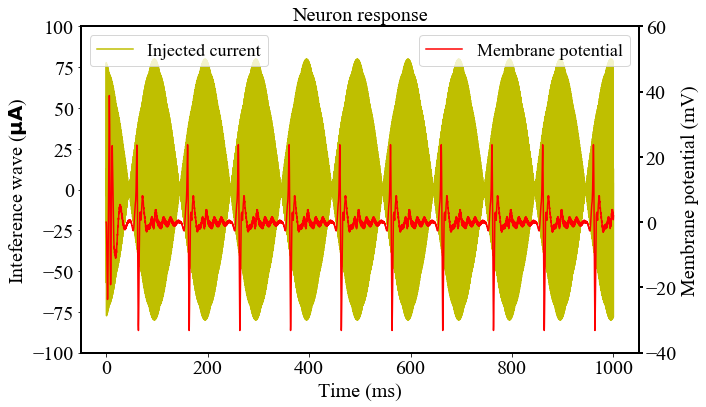

(40001,)


23.75165256164011

In [20]:
neural_sti(20)


In [2]:
print(dataarray.shape)
time = np.arange(0, 1, 0.025e-3) 
print(time.shape)
num = time.shape
y = np.zeros(num[0])
plt.figure()
plt.plot(time,dataarray[0:40000])

NameError: name 'dataarray' is not defined

In [ ]:
import pylab as pl

sampling_rate = 40000
fft_size = 20000 #FFT处理的取样长度
t = np.arange(0, 1.0, 1.0/sampling_rate)#np.arange(起点，终点，间隔)产生1s长的取样时间
# x = np.sin(2*np.pi*156.25*t) + 2*np.sin(2*np.pi*234.375*t)#两个正弦波叠加，156.25HZ和234.375HZ
# N点FFT进行精确频谱分析的要求是N个取样点包含整数个取样对象的波形。因此N点FFT能够完美计算频谱对取样对象的要求是n*Fs/N（n*采样频率/FFT长度），
# 因此对8KHZ和512点而言，完美采样对象的周期最小要求是8000/512=15.625HZ,所以156.25的n为10,234.375的n为15。
xs = dataarray[:fft_size]# 从波形数据中取样fft_size个点进行运算
xf = np.fft.rfft(xs)/fft_size# 利用np.fft.rfft()进行FFT计算，rfft()是为了更方便对实数信号进行变换，由公式可知/fft_size为了正确显示波形能量
# rfft函数的返回值是N/2+1个复数，分别表示从0(Hz)到sampling_rate/2(Hz)的分。
#于是可以通过下面的np.linspace计算出返回值中每个下标对应的真正的频率：
freqs = np.linspace(0, sampling_rate/2, fft_size/2+1)
# np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
#在指定的间隔内返回均匀间隔的数字
xfp = 20*np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
#最后我们计算每个频率分量的幅值，并通过 20*np.log10()将其转换为以db单位的值。为了防止0幅值的成分造成log10无法计算，我们调用np.clip对xf的幅值进行上下限处理

#绘图显示结果
pl.figure(figsize=(8,4))
pl.subplot(211)
pl.plot(t[:fft_size], xs)
pl.xlabel(u"Time(S)")
pl.title(u"membrame voltage and FFT transform")
pl.ylim([-70,50])
pl.subplot(212)
pl.plot(freqs, xfp)
pl.xlabel(u"Freq(Hz)")
pl.xlim([0,5000])
pl.subplots_adjust(hspace=0.4)
pl.show()


In [ ]:
[row,col] = data2.shape[0:2]
HB = np.zeros([row,col])
for i in range(20,60):
    for j in range(20,60):
        if np.isnan(HA[i,j]):
            HB[i,j] = np.nan
        else:
            HB[i,j] = neural_sti(HA[i,j])
        print("pixe {},{} number {}".format(i,j,HB[i,j]))
            

In [ ]:
[row,col] = data2.shape[0:2]
HB = np.zeros([row,col])
for i in range(20,60):
    for j in range(25,55):
        data_piece = data2[i,j,:]
        data_stack = np.tile(data_piece,3)
        HB[i,j] = neural_sti2(5*10e5*data_stack[0:6001])
        print("pixe {},{} number {}".format(i,j,HB[i,j]))

In [ ]:
print(np.max(HB))

In [ ]:
from scipy import ndimage
out1 = ndimage.rotate(HB, 180)
plt.imshow(out1)

In [ ]:
np.max(HB)

In [ ]:
sio.savemat('output2-1.mat', {'data':HB})